In [79]:
from RSA import rsa_decrypt, rsa_encrypt
from RSA_with_blinding import secure_decrypt
from Crypto.Util.number import bytes_to_long
import json
import time
from Crypto.Random import get_random_bytes
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import scipy.stats as stats

In [80]:
# Function modified to include printing category splits by percentage
def categorise_keys(file_path):
    with open(file_path, 'r') as f:
        keys_data = json.load(f)

    # Calculate hamming weight percentage and keep track of each key and its percentage
    keys_with_percentages = []
    for key in keys_data:
        d = int(key['private_key']['d'])
        hw = bin(d).count('1')
        total_bits = d.bit_length()
        percentage = (hw / total_bits) * 100
        keys_with_percentages.append((key, percentage))
    
    # Sort the keys by their Hamming weight percentage
    keys_with_percentages.sort(key=lambda x: x[1])

    # Calculate the size of each category
    category_size = len(keys_with_percentages) // 3

    # Initialize categories
    categories = {'Low': [], 'Medium': [], 'High': []}

    # Evenly distribute the keys into the three categories
    for i, (key, percentage) in enumerate(keys_with_percentages):
        if i < category_size:
            categories['Low'].append((key, percentage))
        elif i < 2 * category_size:
            categories['Medium'].append((key, percentage))
        else:
            categories['High'].append((key, percentage))

    return categories

file_path = 'rsa_keys.json'
categories = categorise_keys(file_path)



In [81]:
# Printing category sizes and percentage ranges
for category in categories:
    print(f"{category}: {len(categories[category])} keys")
    if categories[category]:
        percentages = [percentage for _, percentage in categories[category]]
        print(f"  Range: {min(percentages):.2f}% to {max(percentages):.2f}%")

Low: 333 keys
  Range: 45.43% to 49.51%
Medium: 333 keys
  Range: 49.51% to 50.46%
High: 334 keys
  Range: 50.46% to 53.30%


In [82]:
def collect_timing_data_for_categories(categories, num_messages=1, message_length=256):
    timing_data = {category: [] for category in categories}

    for category, items in categories.items():
        for item in items:
            public_key, private_key = item[0]['public_key'], item[0]['private_key']  # Adjusted to match structure
            for _ in range(num_messages):
                message_bytes = get_random_bytes(message_length)  # Generate message as bytes
                message_int = bytes_to_long(message_bytes)  # Convert message to integer
                ciphertext = rsa_encrypt(public_key, message_int)  # Encrypt the integer message
            
                start = time.perf_counter()
                secure_decrypt(ciphertext, private_key, public_key)
                end = time.perf_counter()
            
                decryption_time = end - start
                timing_data[category].append(decryption_time)
    
    return timing_data


timing_data = collect_timing_data_for_categories(categories)


In [87]:
# Convert the timing results to a format suitable for analysis and plotting
timings = []
weights = []
for hw, times in timing_data.items():
    timings.extend(times)  # Add all timings to the list
    weights.extend([hw] * len(times))  # Repeat the hamming weight for each timing value

data = pd.DataFrame({
    'Decryption Time': timings,
    'Hamming Weight': weights
})

# Convert to numpy arrays for easier statistical analysis
timings = np.array(timings)
weights = np.array(weights)

# Conduct basic statistical analysis
# Example: Calculate mean decryption time for each Hamming weight
unique_weights = np.unique(weights)
mean_times = {weight: np.mean(timings[weights == weight]) for weight in unique_weights}
print("Mean decryption times by Hamming weight:", mean_times)

Mean decryption times by Hamming weight: {'High': 1.374482671377282, 'Low': 1.3613758577717905, 'Medium': 1.3697423439340024}


In [88]:
# Assuming 'data' is your DataFrame and it has columns 'Decryption Time' and 'Hamming Weight'

# First, let's categorize your decryption times based on Hamming Weight
low_times = data[data['Hamming Weight'] == 'Low']['Decryption Time']
medium_times = data[data['Hamming Weight'] == 'Medium']['Decryption Time']
high_times = data[data['Hamming Weight'] == 'High']['Decryption Time']

# Kruskal-Wallis H-test
h_value, p_value = stats.kruskal(low_times, medium_times, high_times)

print('Kruskal-Wallis H-test results: H-value =', h_value, 'P-value =', p_value)

# Interpret the results
if p_value < 0.05:
    print("The differences between the groups are statistically significant.")
else:
    print("The differences between the groups are not statistically significant.")

Kruskal-Wallis H-test results: H-value = 478.73957009252763 P-value = 1.1041376522781548e-104
The differences between the groups are statistically significant.


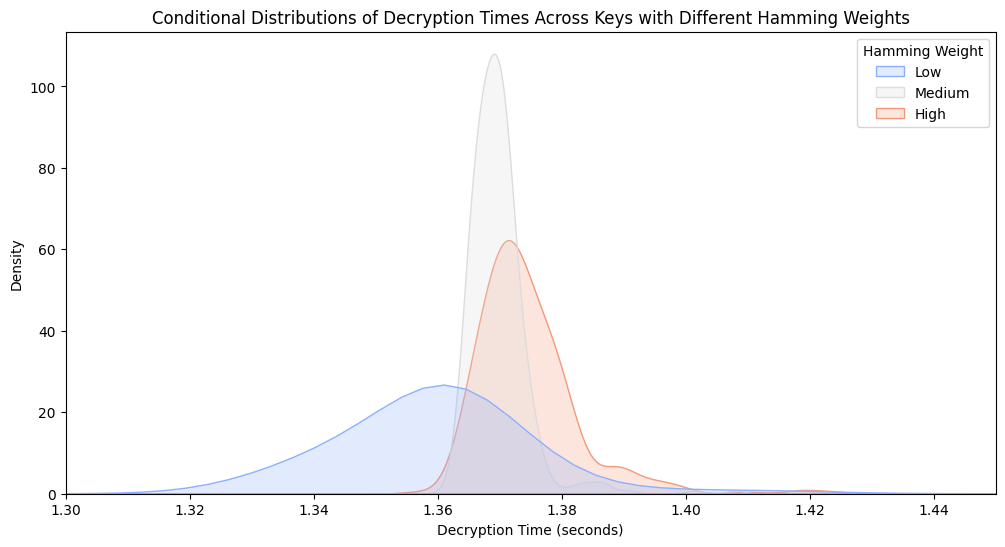

In [91]:
plt.figure(figsize=(12, 6))
sns.kdeplot(
    data=data, 
    x='Decryption Time', 
    hue='Hamming Weight', 
    common_norm=False, 
    palette="coolwarm", 
    fill=True,
    bw_adjust=1
)
plt.xlim(1.3, 1.45)  # Set the x-axis limits to focus on the relevant range
plt.title('Conditional Distributions of Decryption Times Across Keys with Different Hamming Weights')
plt.xlabel('Decryption Time (seconds)')
plt.ylabel('Density')
plt.show()


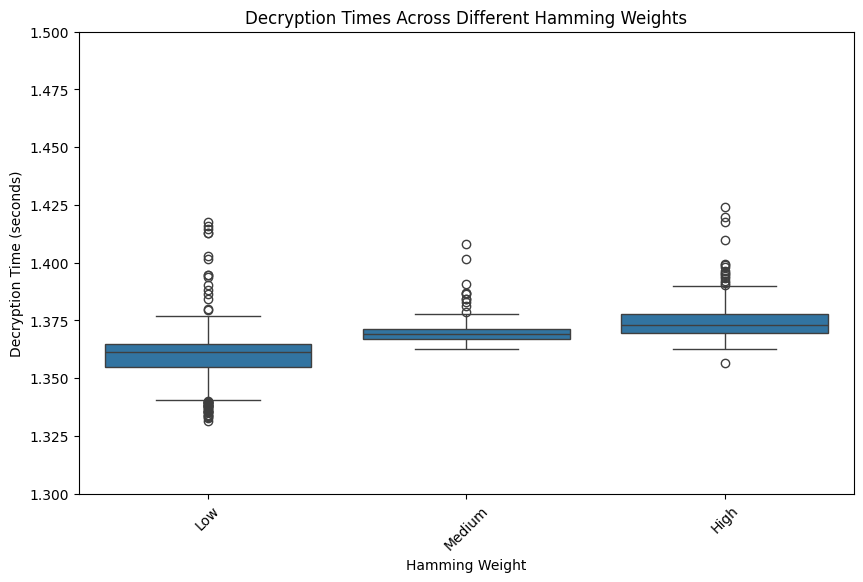

In [92]:
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
sns.boxplot(x='Hamming Weight', y='Decryption Time', data=data)

plt.title('Decryption Times Across Different Hamming Weights')
plt.xlabel('Hamming Weight')
plt.ylabel('Decryption Time (seconds)')
plt.xticks(rotation=45)  # Rotate x-axis labels if necessary for better readability
plt.ylim(1.3, 1.5)
plt.show()